In [1]:
from dataloaders.voc_2007 import VOC2007DataLoader
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import types
from models.mobilenetv2 import MobileNetV2
import torchvision.models as models
import torch
from itertools import cycle

In [2]:
dataloader = VOC2007DataLoader()
dataiter = iter(dataloader.train)

Using downloaded and verified file: ./dataloaders/datasets/voc2007/VOCtrainval_06-Nov-2007.tar


In [3]:
image, target = dataiter.next()

In [4]:
def generate_bounding_box(xmin, xmax, ymin, ymax):
    # convert to bottom left corner and width/height
    x, y = xmin, ymin
    width, height = xmax - xmin, ymax - ymin

    return Rectangle((x,y),width,height,linewidth=1,edgecolor='r',fill=False)

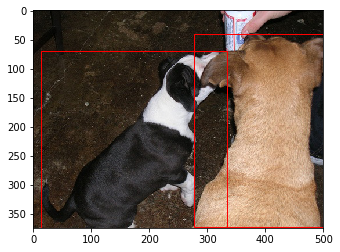

In [5]:
plt.imshow(image.numpy()[0].transpose(1,2,0))

input_width, input_height = float(target['annotation']['size']['width'][0]), float(target['annotation']['size']['height'][0])
# width_ratio, height_ratio = 800/int(width), 800/int(height)
ax = plt.gca()

objects = target['annotation']['object']
objects = [objects] if isinstance(objects, dict) else objects
object_boxes = []

for obj in objects:
    xmin = float(obj['bndbox']['xmin'][0])
    xmax = float(obj['bndbox']['xmax'][0])
    ymin = float(obj['bndbox']['ymin'][0])
    ymax = float(obj['bndbox']['ymax'][0])
    object_boxes.append([xmin, xmax, ymin, ymax])

    ax.add_patch(generate_bounding_box(xmin, xmax, ymin, ymax))
plt.show()


In [6]:
head = MobileNetV2()

In [7]:
feature_map = head(image)
map_height, map_width = feature_map.shape[2:4]

feature_map.shape
#plt.imshow(feature_map.numpy()[0][0])

torch.Size([1, 232, 24, 32])

In [8]:
def generate_anchor_group(center, input_width, input_height, base_size=32):
    scales = [4, 8, 16]
    aspect_ratios = [0.5, 1, 2] # 1:2, 1:1, 2:1
    
    # all anchors with all scales and aspect ratios
    anchor_group = np.zeros((len(scales) * len(aspect_ratios), 4))
    
    for i, scale in enumerate(scales):
        for j, aspect_ratio in enumerate(aspect_ratios):
            width = base_size * scale * np.sqrt(aspect_ratio)
            height = base_size * scale * np.sqrt(1./aspect_ratio)
            
            # if anchor is outside image bounds, clip it.
            x1 = max(0, center[0] - width / 2.)
            x2 = min(center[0] + width / 2., input_width)
            y1 = max(0, center[1] - height / 2.)
            y2 = min(center[1] + height / 2., input_height)
            
            #store the generated anchor in group
            anchor_group[i * len(aspect_ratios) + j] = [x1, x2, y1, y2]
    
    return anchor_group        

(6417, 4)


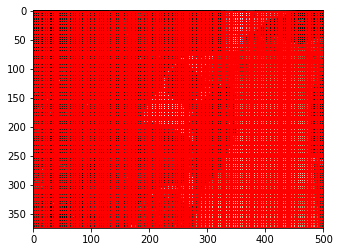

In [9]:
plt.imshow(image.numpy()[0].transpose(1,2,0))
#plt.imshow(feature_map.numpy()[0][0])

ax = plt.gca()
subsample_ratio = 16

centers_x = np.arange(subsample_ratio, (input_width // subsample_ratio +1) * subsample_ratio , subsample_ratio)
centers_y = np.arange(subsample_ratio, (input_height // subsample_ratio +1) * subsample_ratio , subsample_ratio)

anchors = []

for center_x in centers_x:
    for center_y in centers_y:
        anchors.append(generate_anchor_group((center_x, center_y), input_width, input_height, base_size=subsample_ratio))
anchors = np.array(anchors)
anchors = anchors.reshape((anchors.shape[0]*9,4))


print(anchors.shape)

for anchor in anchors: 
    ax.add_patch(generate_bounding_box(*anchor))

plt.show()

In [10]:
def intersection_over_union(box1, box2):
    # area of inters. / area of union
    # calculate the area of intersection by getting the lowest x2,y2 and highest x1,y1
    x1 = max(box1[0], box2[0])
    y1 = max(box1[2], box2[2])
    x2 = min(box1[1], box2[1])
    y2 = min(box1[3], box2[3])
    
    if (x1 < x2) and (y1 < y2):
        intersection = (x2 - x1) * (y2 - y1)
    else:
        intersection = 0
       
    # area of union is area of 1 + area of 2 - intersection
    area1 = (box1[1] - box1[0]) * (box1[3] - box1[2])
    area2 = (box2[1] - box2[0]) * (box2[3] - box2[2])
    
    iou = intersection / (area1 + area2 - intersection)
    
    return iou

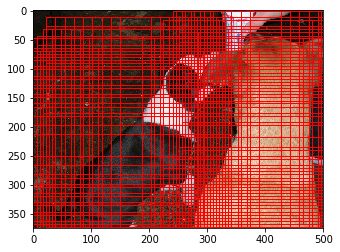

In [11]:
# calculate iou scores between each ground thruth box and anchor
FG_THRESHOLD = 0.5
BG_THRESHOLD = 0.1

iou_scores = np.empty((len(anchors), len(object_boxes)))
for i, object_box in enumerate(object_boxes):
    iou_scores[:, i] = [intersection_over_union(anchor, object_box) for anchor in anchors]

# retrieve a list of anchors with a iou lower than threshold
background_anchors = [anchor_idx for anchor_idx, scores in enumerate(iou_scores) if np.all(scores < BG_THRESHOLD)]

# for foreground, also store the index of the corresponding ground thruth box (all in a tupple) --> (anchor_idx, box_idx)
# if there are no anchors above the threshold, retrieve the one with the highest scoore
foreground_anchors = []
for box_idx, scores in enumerate(np.transpose(iou_scores)):
    foreground_idx = list(np.argwhere(scores > FG_THRESHOLD).flatten())
    if len(foreground_idx) == 0:
        foreground_idx = [np.argmax(scores)]
    foreground_anchors+= list(zip(foreground_idx, cycle([box_idx])))


plt.imshow(image.numpy()[0].transpose(1,2,0))
ax = plt.gca()
for anchor in foreground_anchors:
    ax.add_patch(generate_bounding_box(*anchors[anchor[0]]))

plt.show()

In [12]:
# generate a batch of 256 background and foreground anchors
# sample uniformly from calculated anchors
# if there aren't enough positive samples, pad with negative

BATCH_SIZE = 256

positive_batch_len = BATCH_SIZE//2 if len(foreground_anchors) > BATCH_SIZE//2 else len(foreground_anchors)
negative_batch_len = BATCH_SIZE - positive_batch_len

positive_batch = np.random.choice(np.arange(len(foreground_anchors)), positive_batch_len)
negative_batch = np.random.choice(background_anchors, negative_batch_len)

print(len(negative_batch), len(positive_batch))



128 128
